In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Reading in data for station
df = pd.read_csv('../data/WOODHAVEN BLVD_26_weeks.csv')
df.head()

,datetime,entries_abs,exits_abs
0,2022-04-09 04:00:00,74.0,254.0
1,2022-04-09 08:00:00,1222.0,500.0
2,2022-04-09 12:00:00,1661.0,1839.0
3,2022-04-09 16:00:00,2082.0,2948.0
4,2022-04-09 20:00:00,1662.0,2379.0


In [3]:
# Looking at the columns and types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091 entries, 0 to 1090
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     1091 non-null   object 
 1   entries_abs  1091 non-null   float64
 2   exits_abs    1091 non-null   float64
dtypes: float64(2), object(1)
memory usage: 25.7+ KB


In [4]:
# Setting the datetime to a datetime object and setting as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace = True)
df.rename(columns = {'entries_abs':'entries', 'exits_abs':'exits'}, inplace = True)
df.sort_index(inplace = True)
df.head()

,entries,exits
datetime,,
2022-04-09 04:00:00,74.0,254.0
2022-04-09 08:00:00,1222.0,500.0
2022-04-09 12:00:00,1661.0,1839.0
2022-04-09 16:00:00,2082.0,2948.0
2022-04-09 20:00:00,1662.0,2379.0


In [5]:
def plot_series(df, cols, title='Title', xlab=None, ylab=None):
    """Function to plot columns for a time period"""
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col], label = col)
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.legend();

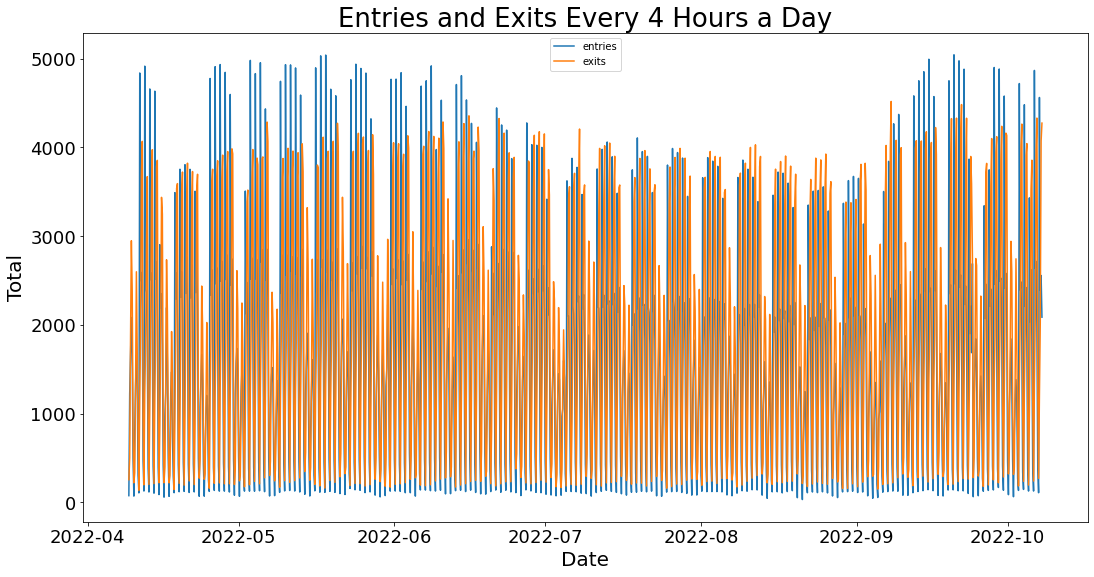

In [6]:
plot_series(df, cols = ['entries', 'exits'], title = 'Entries and Exits Every 4 Hours a Day', xlab = 'Date', ylab = 'Total')

In [7]:
#plot_series(df, cols = ['exits'], title = 'Exits per time of day')

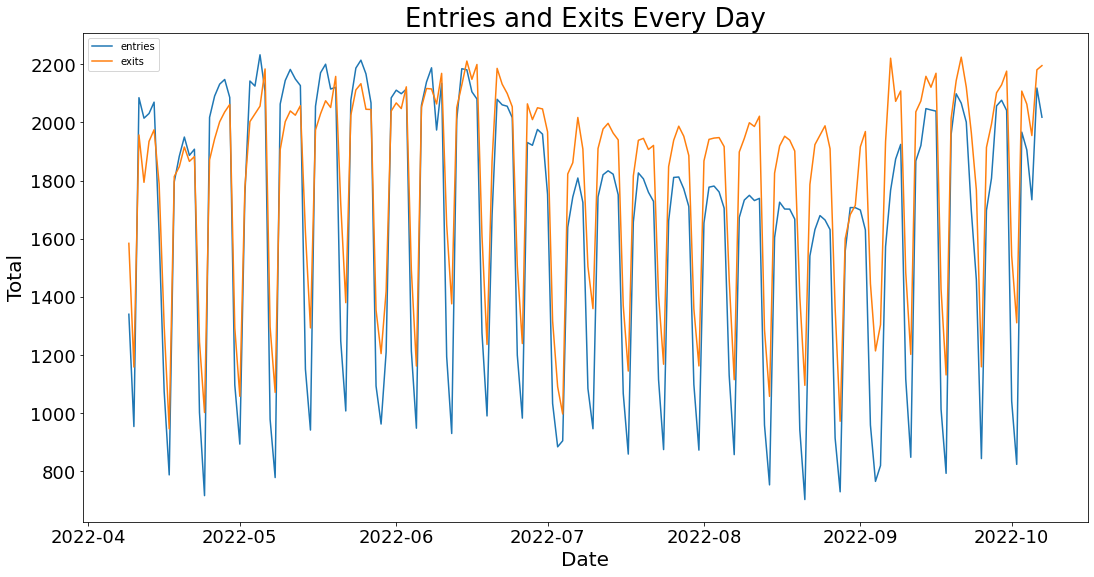

In [8]:
df_daily = df.resample('D').mean()
plot_series(df_daily, cols = ['entries', 'exits'], title = 'Entries and Exits Every Day', xlab = 'Date', ylab = 'Total')

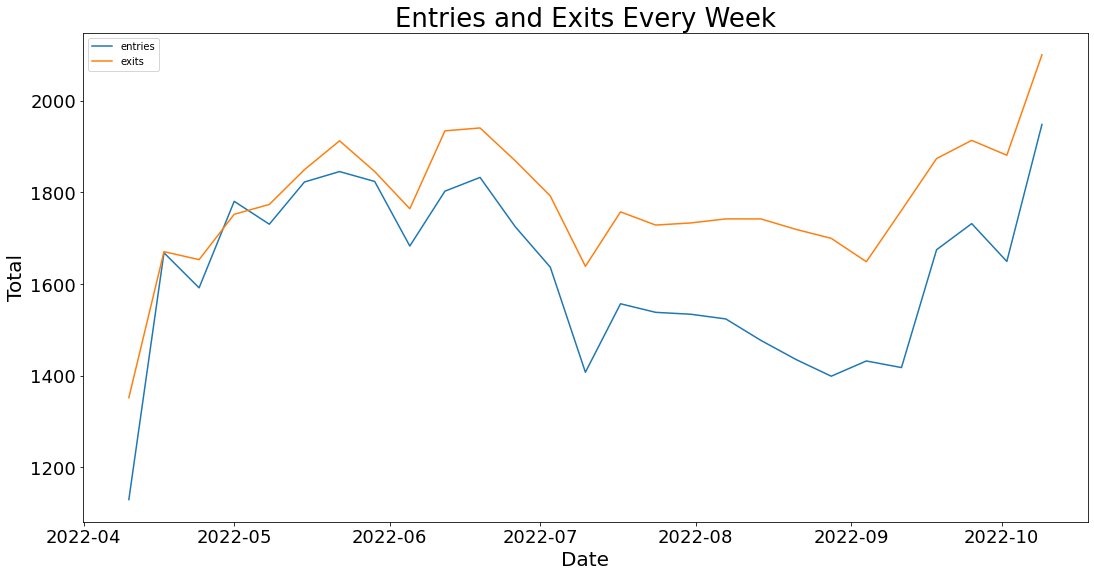

In [9]:
df_weekly = df.resample('W').mean()
plot_series(df_weekly, cols = ['entries', 'exits'], title = 'Entries and Exits Every Week', xlab = 'Date', ylab = 'Total')

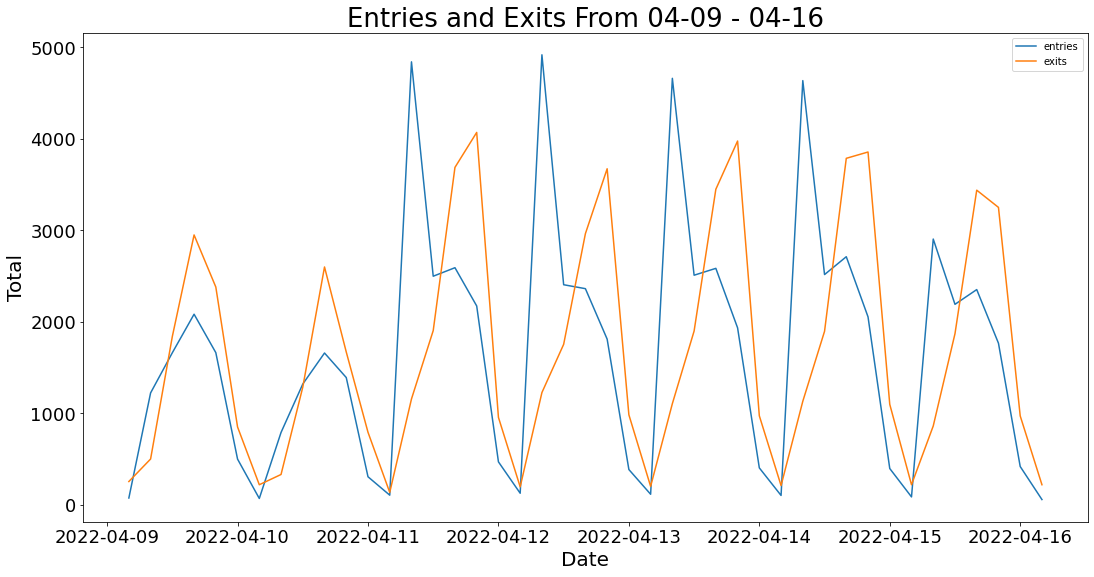

In [10]:
plot_series(df.loc['2022-04-09 04:00:00':'2022-04-16 04:00:00'], cols = ['entries', 'exits'], title = 'Entries and Exits From 04-09 - 04-16', xlab = 'Date', ylab = 'Total')

# Evaluating For Stationarity

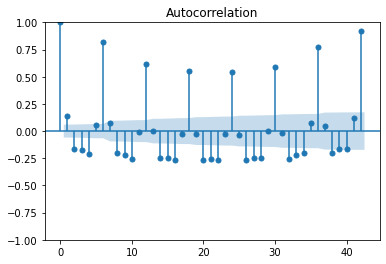

In [11]:
plot_acf(df['entries'], lags = 42);

- We can see that we have high correlation in every lag of 6. This is because for each lag of 6 an entire day passes. It also gets extremely high once it reaches 42 because thats after an entire week passes.

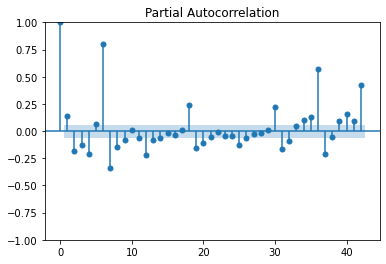

In [12]:
plot_pacf(df['entries'], lags = 42, method = 'ywm');

 - Using the pacf we can see that some of the correlation the acf was showing us was due to lags having a correlation to the lags in between the first lag. The majority of the lags of multiples of 6 are still standing out, but some of the negative lags in between for the autocorrelation below the significance threshold now. 

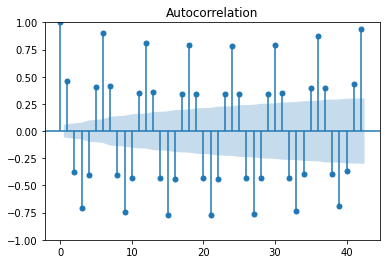

In [13]:
plot_acf(df['exits'], lags = 42);

- Opposed to the entries acf we have more negatively correlated lags and their significance is almost just as high as the positive lags' correlation.

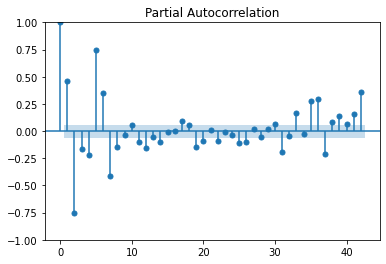

In [14]:
plot_pacf(df['exits'], lags = 42, method = 'ywm');

- We get the same drop off again however and see that most of the lags are the middle aren't as significant as they were in comparison to the acf.

In [15]:
# Use the augmented dickey-fuller test to test if our data is stationary
# Code from lesson on Arima Models to extract needed values 
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [16]:
interpret_dftest(adfuller(df['entries']))

Test Statistic   -9.140339e+00
p-value           2.860707e-15
dtype: float64

In [17]:
interpret_dftest(adfuller(df['exits']))

Test Statistic   -9.703949e+00
p-value           1.054049e-16
dtype: float64

- Since we have p values of less than 0.05 we can confidently say our data is stationary. This means we won't have to difference our data for our AR model

# Creating AR Models

In [18]:
y_train, y_test = train_test_split(df['entries'], test_size = 0.2, shuffle = False)
arima = ARIMA(endog = y_train, order = (1, 0, 0), freq ='4H')
model = arima.fit()
print(f'The AIC for ARIMA(1, 0, 0) is : {model.aic}')


The AIC for ARIMA(1, 0, 0) is : 14928.02969680079


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


In [ ]:
def evaluate_model(df, p, d, q):

In [19]:
def AR_model_gridsearch(df, p_values, d_values, q_values):
    
    #Creating train test split for data
    y_train, y_test = train_test_split(df, test_size = 0.2, shuffle = False)
    
    best_aic = 999999
    best_order  = (0, 0, 0)
    for p in p_values: 
        for d in d_values:
            for q in q_values:
                try: 
                    
                    print(f'ARIMA:({p},{d},{q})')
                    
                    arima = ARIMA(endog = y_train, order = (p, d, q), freq = '4H')
                    
                    model = arima.fit()
                    
                    print(f'The AIC for ARIMA({p}, 0, {q}) is : {model.aic}')
                    
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        
                except:
                    print('failed')
                    pass
                
    print()
    print()
    print(f'Our model that minimizes AIC on the training data is the ARIMA{best_order}.')
    print(f'This model has an AIC of {best_aic}.')

In [20]:
p_values = range(0,22)
d_values = [0] #Since the data is already stationary
q_values = range(0,2) # To check the MA of 1 lag

AR_model_gridsearch(df['entries'], p_values, d_values, q_values)

C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


ARIMA:(0,0,0)
The AIC for ARIMA(0, 0, 0) is : 14943.64197522494
ARIMA:(0,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(0, 0, 1) is : 14919.80656325196
ARIMA:(1,0,0)
The AIC for ARIMA(1, 0, 0) is : 14928.02969680079
ARIMA:(1,0,1)
The AIC for ARIMA(1, 0, 1) is : 14916.175354716075
ARIMA:(2,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(2, 0, 0) is : 14896.123169709124
ARIMA:(2,0,1)
The AIC for ARIMA(2, 0, 1) is : 14882.425995274665
ARIMA:(3,0,0)
The AIC for ARIMA(3, 0, 0) is : 14883.999565593283
ARIMA:(3,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(3, 0, 1) is : 14877.614231880143
ARIMA:(4,0,0)
The AIC for ARIMA(4, 0, 0) is : 14842.586832394292
ARIMA:(4,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(4, 0, 1) is : 14843.943329649881
ARIMA:(5,0,0)
The AIC for ARIMA(5, 0, 0) is : 14839.185336600047
ARIMA:(5,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(5, 0, 1) is : 14701.729567073262
ARIMA:(6,0,0)
The AIC for ARIMA(6, 0, 0) is : 13927.5641148602
ARIMA:(6,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(6, 0, 1) is : 13852.26347107224
ARIMA:(7,0,0)
The AIC for ARIMA(7, 0, 0) is : 13813.196918028554
ARIMA:(7,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(7, 0, 1) is : 13780.95599034571
ARIMA:(8,0,0)
The AIC for ARIMA(8, 0, 0) is : 13791.977190196269
ARIMA:(8,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(8, 0, 1) is : 13787.686266788842
ARIMA:(9,0,0)
The AIC for ARIMA(9, 0, 0) is : 13788.741968315197
ARIMA:(9,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(9, 0, 1) is : 13790.32565318215
ARIMA:(10,0,0)
The AIC for ARIMA(10, 0, 0) is : 13790.240366999406
ARIMA:(10,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(10, 0, 1) is : 13792.56664720538
ARIMA:(11,0,0)
The AIC for ARIMA(11, 0, 0) is : 13789.076224539642
ARIMA:(11,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(11, 0, 1) is : 13776.726020943373
ARIMA:(12,0,0)
The AIC for ARIMA(12, 0, 0) is : 13742.477677553677
ARIMA:(12,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(12, 0, 1) is : 13735.963426074786
ARIMA:(13,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(13, 0, 0) is : 13738.830940859963
ARIMA:(13,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(13, 0, 1) is : 13738.299714857198
ARIMA:(14,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(14, 0, 0) is : 13736.712177882053
ARIMA:(14,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(14, 0, 1) is : 13738.673489752988
ARIMA:(15,0,0)
The AIC for ARIMA(15, 0, 0) is : 13738.679043492317
ARIMA:(15,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(15, 0, 1) is : 13740.630089591832
ARIMA:(16,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(16, 0, 0) is : 13740.115729049918
ARIMA:(16,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(16, 0, 1) is : 13742.079899819875
ARIMA:(17,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(17, 0, 0) is : 13741.987124712694
ARIMA:(17,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(17, 0, 1) is : 13716.008347416388
ARIMA:(18,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(18, 0, 0) is : 13691.307752718763
ARIMA:(18,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(18, 0, 1) is : 13676.555484153763
ARIMA:(19,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(19, 0, 0) is : 13663.358042310389
ARIMA:(19,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(19, 0, 1) is : 13652.887116060963
ARIMA:(20,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(20, 0, 0) is : 13656.252161456006
ARIMA:(20,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(20, 0, 1) is : 13658.360360233182
ARIMA:(21,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)


The AIC for ARIMA(21, 0, 0) is : 13655.667049316526
ARIMA:(21,0,1)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 4H will be used.
  self._init_dates(dates, freq)
C:\Users\injun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The AIC for ARIMA(21, 0, 1) is : 13657.638373368743


Our model that minimizes AIC on the training data is the ARIMA(19, 0, 1).
This model has an AIC of 13652.887116060963.


In [21]:
#Evaluate the model
lr.score(X_train, y_train), lr.score(X_test,y_test)

NameError: name 'lr' is not defined

In [ ]:
pred = lr.predict(X_test)

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(y_test, label = 'y_test')
plt.plot(y_test.index, pred, label = 'test_pred')
plt.legend();

In [ ]:
mean_squared_error(y_test, pred, squared=False) 